# Double Descent with Random Fourier Features

In this section, we will demonstrate the double descent phenomenon when performing regression with Random Fourier Features (RFF).  Given a dataset $\{(x^{(i)}, y^{(i)})\}_{i=1}^{n} \subset \mathbb{R}^{d} \times \mathbb{R}$, we wish to learn a map from $x^{(i)} \to y^{(i)}$.  In order to learn this map, we will first transform the features $x^{(i)}$ via the following \textbf{feature map}: 

\begin{align*}
    \phi_k(x) = \frac{1}{\sqrt{k}} \begin{bmatrix} e^{i \langle v^{(1)}, x \rangle}\\
                                                 e^{i \langle v^{(1)}, x \rangle} \\
                                                 \vdots \\
                                                 e^{i \langle v^{(k)}, x \rangle}
                                                 \end{bmatrix}~~;
\end{align*}
where $v^{(j)} \sim \mathcal{N}(\mathbf{0}, I_{d \times d})$ for $j = 1, 2, \ldots, k$.  It is important to note that $\phi_k(x) \in \mathbb{C}^{k}$ and that the inner product in this space is given by: 
\begin{align*}
    \langle u, v \rangle = \sum_{i=1}^{k} u_k \bar{v}_k
\end{align*}
where $\bar{v}_k$ is the complex conjugate of $v_k$.  Given the map $\phi_k: \mathbb{R}^{d} \to \mathbb{C}^{k}$, we now use linear regression to map from $\phi_k(x^{(i)}) \to y^{(i)}$.  In particular, we use gradient descent to minimize the following loss: 
\begin{align}
    \mathcal{L}(w) = \sum_{i=1}^{n} ( y^{(i)} - w^T \phi_k(x^{(i)}))^2 
\end{align}

### Connection to Neural Networks

From the form of the loss function above, we see that the RFF model above is equivalent to a neural network with 1 hidden layer with $k$ hidden units and an elementwise activation function, $\psi: \mathbb{R} \to \mathbb{C}$, with $\psi(\xi) = \frac{1}{\sqrt{k}} e^{i \xi}$.


## Double Descent with Increasing Width
We next show that increasing $k$ (e.g. the width of the 1 hidden layer network above) empirically leads to double descent.  

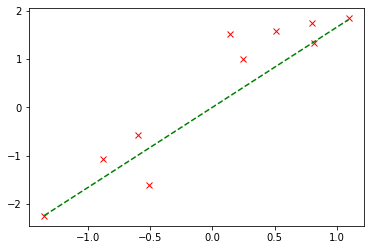

In [65]:
import dataloader as dl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 2134

np.random.seed(SEED)
# Dataset for regression
X, y, X_test, y_test, w = dl.make_dataset(n=10, d=1, eps=.5)

# Visualize Dataset (red) and True Solution (green)
plt.plot(X[0], y[0], 'rx')
plt.plot(X_test[0], y_test[0], 'g--')
plt.show()


### Code for RFF Regression with Finite Number of Features

1 1.9013119603246775 1.2049208764513415
5 0.17278681076158883 472.9248745370769
10 1.3858351510153538e-07 2.8522195042831014e+21
50 0 3217438971143.833
100 0 8467710151.176084
500 0 62558628.159007974
1000 0 15646312.643174944
5000 0 227626.01407115083
10000 0 37038.53470926179
100000 0 2056.558210257892


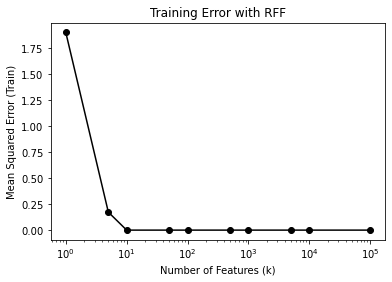

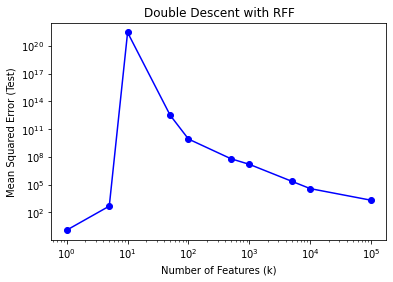

In [66]:
from numpy.linalg import pinv
SEED = 2134
np.random.seed(SEED)

def mse(preds, labels): 
    return np.mean(np.abs(np.power(preds - labels, 2)))
    

def RFF(X, k=100):
    d, n = X.shape
    V = np.random.randn(k, d)
    rff = 1/np.sqrt(k) * np.exp(1j * V @ X)
    return rff


# Vary the number of RFF used for regression
num_features = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 100000]
train_errors = []
test_errors = []

for num_feat in num_features: 
    # Compute RFF for train & test data
    phi_X = RFF(X, k=num_feat)
    phi_X_test = RFF(X_test, k=num_feat)
            
    # Solve linear regression on RFF
    w_hat = y @ pinv(phi_X)
    preds = w_hat @ phi_X_test

    # Compute MSE for test samples
    test_error = mse(preds, y_test)
    test_errors.append(test_error)
    
    train_error = mse(w_hat @ phi_X, y)
    if np.isclose(train_error, 0): 
        train_error = 0
    train_errors.append(train_error)
    print(num_feat, train_error, test_error)

    
plt.plot(num_features, train_errors, 'ko-')
plt.title("Training Error with RFF")
plt.xscale("log")
plt.xlabel("Number of Features (k)")
plt.ylabel("Mean Squared Error (Train)")
plt.show()

plt.plot(num_features, test_errors, 'bo-')
plt.title("Double Descent with RFF")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Features (k)")
plt.ylabel("Mean Squared Error (Test)")
plt.show()    

We make the following observations from the above figure: 

1. The test error peaks when using 10 features (e.g. the number of features = the number of training samples).  This is not coincidental, we can actually prove that the error goes to infinity even for over-parameterized linear regression. 

2. The test error decreases when using greater than 10 features.  

Observation 2 above begs the questions: What happens as we increase the number of features to infinity? We now analyze this case in the following section.

## RFF with Infinitely Many Features

We will now show that using infinitely many RFF above (i.e. $k \to \infty$) is equivalent to solving kernel regression with the Gaussian kernel (aka the Radial Basis Function kernel).  To find the corresponding kernel when using infinitely many features, we compute the following inner product as $k \to \infty$: 
\begin{align*}
    \langle \phi_k(x), ~\phi(x') \rangle_{\mathcal{C}^{k}} &= \frac{1}{k} \sum_{j=1}^{k} e^{i \langle v^{(j)}, ~x \rangle} e^{-i \langle v^{(j)}, ~x' \rangle} ~~ \text{(Don't forget the negative from the conjugate.)} \\
    &= \frac{1}{k} \sum_{j=1}^{k} e^{i \langle v^{(j)} , ~ (x - x') \rangle }
\end{align*}

As $k \to \infty$, we apply the law of large numbers to conclude that: 
\begin{align*}
    \langle \phi_k(x), ~\phi(x') \rangle_{\mathcal{C}^{k}} &\to \mathbb{E}_{v \sim \mathcal{N}(\mathbf{0}, I_{d \times d})} \left[e^{i \langle v , ~ (x - x') \rangle } \right] \\
    &= \prod_{\ell=1}^{d} \frac{1}{\sqrt{2\pi}} \int_{\mathbb{R}} e^{i v_{\ell} (x_{\ell} - x'_{\ell})} e^{-\frac{v_{\ell}^2}{2}} dv \\
    &= \prod_{\ell=1}^{d} e^{- (x_{\ell} - x'_{\ell})^2} \\
    &= e^{- \| x - x'\|_2^2}
\end{align*}

Now that we have a closed form for the inner product $\langle \phi_k(x), ~\phi(x') \rangle_{\mathcal{C}^{k}}$ as $k \to \infty$, we can use the representer theorem to analyze the performance of the infinite width RFF model.  

### Kernel Regression with the Gaussian Kernel

Infinite Width Test Error:  3.1646470696652775


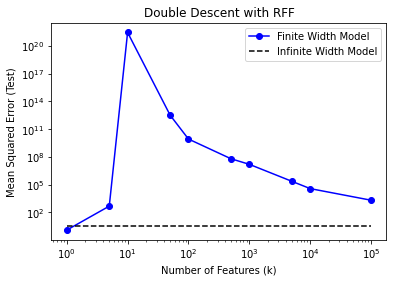

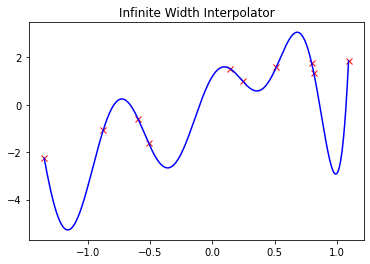

In [84]:
def euclidean_distances(X, Z, squared=True):
    X_norm = np.sum(np.power(X, 2), axis=1, keepdims=True)
    Z_norm = np.sum(np.power(Z, 2), axis=1, keepdims=True).reshape(1, -1)

    distances = X @ Z.T * -2 + X_norm + Z_norm
    
    if not squared:
        distances = np.clip(distances, a_min=0, a_max=None)
        distances.sqrt_()
    return distances


def gaussian_kernel(X, X_):
    kernel_mat = euclidean_distances(X, X_)
    kernel_mat = np.clip(kernel_mat, a_min=0, a_max=None) * -1  
    kernel_mat = np.exp(kernel_mat)
    return kernel_mat

# Build kernel matrix for train & test data
K_train = gaussian_kernel(X.T, X.T)
K_test = gaussian_kernel(X.T, X_test.T)
# Solve kernel regression
a_hat = y @ pinv(K_train)

# Get error on train & test data
train_error = mse(a_hat @ K_train, y)
test_error =mse(a_hat @ K_test, y_test)

print("Infinite Width Test Error: ", test_error)
plt.plot(num_features, test_errors, 'bo-', label='Finite Width Model')
plt.plot(num_features, [test_error]*len(num_features), 'k--', label='Infinite Width Model')
plt.legend()
plt.title("Double Descent with RFF")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Features (k)")
plt.ylabel("Mean Squared Error (Test)")
plt.show()

plt.plot(X[0], y[0], 'rx')
plt.plot(X_test[0], (a_hat @ K_test)[0], 'b-')
plt.title("Infinite Width Interpolator")
plt.show()